In [3]:
import torch
import torchvision # for datasets and transformation for CV tasks
import torchvision.transforms as transforms # for data pre processing
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# compose is for chaining multiple transformations and applied sequentially
# ToTensor() converts PIL images or NumPy arrays to PyTorch tensors and also does normalization


batch_size = 4 # tensor shape is [batch_size, channels, height, width]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Loads the 50,000 training images. train=True selects the training split, and transform applies your preprocessing.

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# DataLoader batches the dataset. batch_size=4 means 4 images per batch, shuffle=True randomizes the order (good for training), and num_workers=2 uses 2 subprocesses for data loading (per docs, this speeds up I/O)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Loads the 10,000 test images with the same transform.

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# Similar to trainloader, but shuffle=False for test data (order doesn’t matter for evaluation).

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:04<00:00, 39.6MB/s]


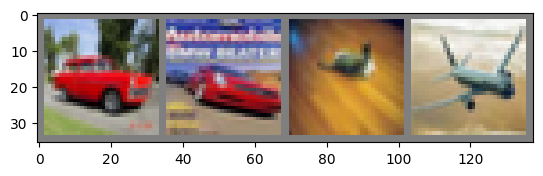

car   car   cat   plane


In [5]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding = 1) # nn.Conv2d(in_channels, out_channels, kernel_size, ...)
    # take 3 input channels, output 32 feature maps, use a 3x3 kernel, and preserve size with padding=1
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
    # take 32 input channels, output 64 feature maps, use a 3x3 kernel, and preserve size with padding=1
    self.fc = nn.Linear(64 * 8 * 8, 10)  # Flatten to 4096, then to 10 classes
    # nn.Linear creates a weight matrix of size [4096, 10] and a bias vector of size [10], performing a matrix multiplication: output = x * weight + bias

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Flatten
    # x.size(0): This is the batch size and 1: This tells PyTorch to automatically calculate the second dimension based on the total number of elements
    x = self.fc(x)
    return x

net = Net()

In [7]:
criterion = nn.CrossEntropyLoss() # loss function for classification
optimizer = optim.Adam(net.parameters(), lr=0.001) # optimization
losses = []

[1,  2000] loss: 0.001
[1,  4000] loss: 0.001
[1,  6000] loss: 0.001
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.001
[2, 12000] loss: 0.001
Finished Training


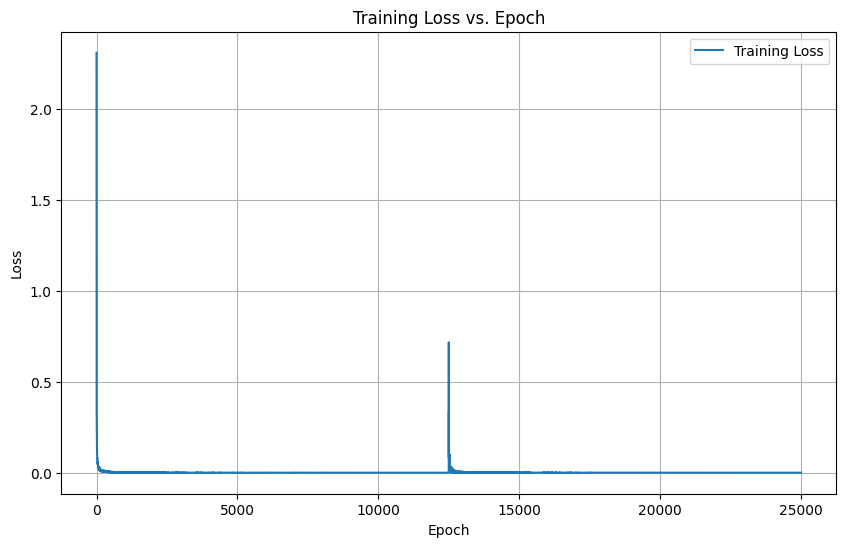

In [8]:
for epoch in range(2): # Runs training for 2 epochs (one pass over the dataset)
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0): # Breaks the 50,000 images into manageable chunks
    inputs, labels = data
    # Unpacks the batch into inputs (image tensors) and labels (target classes)
    # Iterates over the trainloader, where i is the batch index (starting at 0), and data is a tuple of (inputs, labels)

    optimizer.zero_grad() # Iterates over the trainloader, where i is the batch index (starting at 0), and data is a tuple of (inputs, labels)
    # Resets gradients to zero before the backward pass, preventing accumulation from previous iterations.

    outputs = net(inputs)
    # to get predictions (shape [batch_size, 10])

    loss = criterion(outputs, labels)
    loss.backward() # Computes gradients of the loss with respect to model parameters (backpropagation)
    optimizer.step() # Updates the model weights using the gradients and the optimizer’s rules

    running_loss += loss.item()
    # Adds the current batch’s loss (a scalar) to a running total. loss.item() extracts the value as a Python number.

    if i%2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

    epoch_loss = running_loss / (i + 1) if i > 0 else running_loss  # Adjust for last batch
    losses.append(epoch_loss)
    running_loss = 0.0

print('Finished Training')

# Now visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

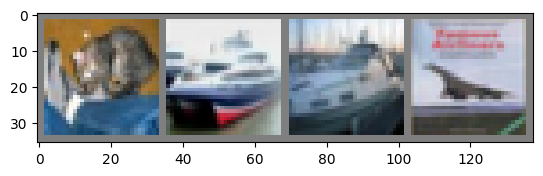

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))